In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import numpy as np
import shapely
import contextily as cx
import matplotlib.pyplot as plt 
import momepy as mm
import osmnx as ox
import matplotlib as plt
from shapely.geometry import LineString, Polygon
import numpy as np
import networkx as nx
from pyproj import CRS, Transformer
from shapely.geometry import Polygon
from scipy.spatial import cKDTree

## get data

In [2]:
# Define the polygon coordinates in EPSG:4326 (WGS84)
polygon_coords_wgs84 = [
    (104.018726, 30.696973),
    (104.112797, 30.697121),
    (104.113827, 30.620778),
    (104.018555, 30.622255)
]

polygon = Polygon(polygon_coords_wgs84)

polygon = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

In [ ]:
%%time
gdf_streets = gpd.read_file("Chengdu_data_streets/成都1.shp", mask=polygon)

In [5]:
gdf_streets = gdf_streets[['RoadID','geometry']]

In [6]:
gdf_streets

,RoadID,geometry
0,590028533.0,"LINESTRING (104.09976 30.62615, 104.09972 30.6..."
1,590028534.0,"LINESTRING (104.09965 30.62657, 104.09958 30.6..."
2,590028911.0,"LINESTRING (104.08660 30.62364, 104.08655 30.6..."
3,590028912.0,"LINESTRING (104.08991 30.62183, 104.09013 30.6..."
4,590028913.0,"LINESTRING (104.09671 30.62620, 104.09697 30.6..."
...,...,...
73847,590949698.0,"LINESTRING (104.09599 30.69384, 104.09606 30.6..."
73848,590949699.0,"LINESTRING (104.09589 30.69388, 104.09599 30.6..."
73849,590949700.0,"LINESTRING (104.09714 30.69793, 104.09716 30.6..."
73850,590926487.0,"LINESTRING (104.08839 30.65739, 104.08873 30.6..."


<Axes: >

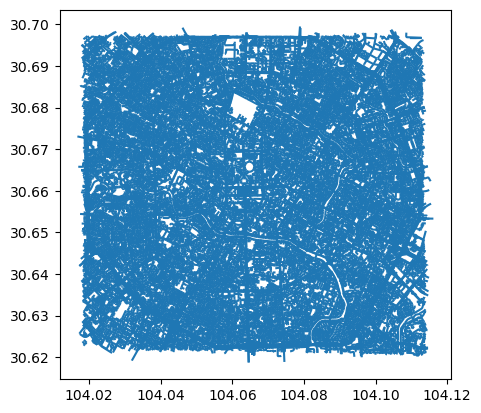

In [7]:
gdf_streets.plot()

In [8]:
%%time
gdf_buildings = gpd.read_file("Chengdu_Data_buildings/Chengdu_Buildings_DWG-Polygon.shp", mask=polygon)

CPU times: total: 13.1 s
Wall time: 13.1 s


In [10]:
gdf_buildings = gdf_buildings[['Elevation','geometry']]

<Axes: >

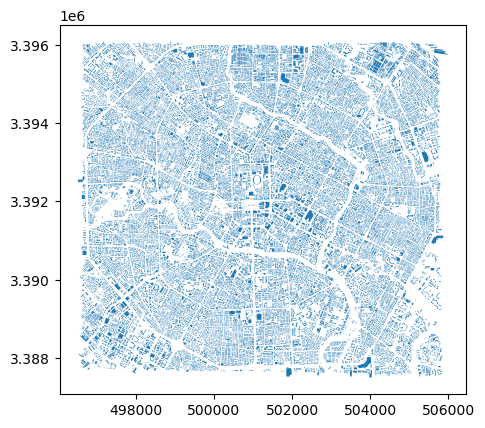

In [11]:
gdf_buildings.plot()

## cleaning

In [12]:
gdf_buildings = gdf_buildings.reset_index(drop=True).explode(index_parts=False).reset_index(drop=True)
gdf_buildings = gdf_buildings[~gdf_buildings.geometry.isna()]
gdf_buildings.geometry = gdf_buildings.buffer(0)

In [13]:
gdf_buildings = gdf_buildings[gdf_buildings.geom_type == "Polygon"].reset_index(drop=True)

In [14]:
gdf_buildings.geom_type.value_counts()

Polygon    40193
Name: count, dtype: int64

In [15]:
gdf_buildings = gdf_buildings.drop_duplicates(["geometry"])

In [16]:
gdf_buildings.geom_type.value_counts()

Polygon    40193
Name: count, dtype: int64

In [17]:
# gdf_t = gdf.copy()

In [18]:
# %time check = mm.CheckTessellationInput(gdf_t)
# %time gdf_t = gdf_t.drop(check.collapse.index.union(check.split.index).union(check.overlap.index))
# %time check = mm.CheckTessellationInput(gdf_t)

In [19]:
gdf_f = gdf_buildings[gdf_buildings.area > 20] #consider only buildings with more than 20m2

In [20]:
gdf_f.geom_type.value_counts()

Polygon    39669
Name: count, dtype: int64

In [21]:
gdf_f["uID"] = range(len(gdf_f))

C:\ProgramData\miniconda3\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
gdf_f.Elevation.isna().sum()

0

In [23]:
gdf_f.rename(columns={'Elevation': 'height'}, inplace=True)

C:\Users\Alessandro Venerandi\AppData\Local\Temp\ipykernel_34040\3806829651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_f.rename(columns={'Elevation': 'height'}, inplace=True)


In [24]:
gdf_f[['uID','height','geometry']].to_file('data/geometry_large.gpkg', layer='buildings')

## get streets

In [25]:
gdf_streets_ = mm.remove_false_nodes(gdf_streets)

C:\ProgramData\miniconda3\envs\ox\Lib\site-packages\geopandas\array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [26]:
gdf_streets_

,RoadID,geometry
0,590028533.0,"LINESTRING (104.09976 30.62615, 104.09972 30.6..."
1,590028534.0,"LINESTRING (104.09965 30.62657, 104.09958 30.6..."
2,590028911.0,"LINESTRING (104.08660 30.62364, 104.08655 30.6..."
3,590028912.0,"LINESTRING (104.08991 30.62183, 104.09013 30.6..."
4,590028913.0,"LINESTRING (104.09671 30.62620, 104.09697 30.6..."
...,...,...
60508,NaN,"LINESTRING (104.11289 30.63939, 104.11303 30.6..."
60509,NaN,"LINESTRING (104.11361 30.62833, 104.11369 30.6..."
60510,NaN,"LINESTRING (104.11329 30.63562, 104.11333 30.6..."
60511,NaN,"LINESTRING (104.11343 30.62290, 104.11353 30.6..."


In [27]:
# add IDs
gdf_streets_['nID'] = range(len(gdf_streets_))

In [28]:
gdf_streets_[['nID','geometry']].to_file('data/geometry_large.gpkg', layer='streets') #write to disk